In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_data
from sklearn.model_selection import train_test_split

import gc

from transformations import trafo_indep, trafo_q

%load_ext line_profiler

In [2]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
tf.test.is_gpu_available()

True

# Prepare data

In [4]:
single_hits, repeated_params, total_charge, params, labels = load_data()

In [5]:
single_hits_train, single_hits_test, repeated_params_train, repeated_params_test = train_test_split(single_hits,repeated_params, test_size=0.01, random_state=42)
total_charge_train, total_charge_test, params_train, params_test = train_test_split(total_charge, params, test_size=0.01, random_state=42)

# Create NNs

In [49]:
# class LossHistory(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self.train_losses = []
#         self.test_losses = []

#     def on_train_batch_end(self, batch, logs={}):
#         self.train_losses.append(logs.get('loss'))
        
#     def on_test_batch_end(self, batch, logs={}):
#         self.test_losses.append(logs.get('loss'))
   

In [71]:
activation='relu'

hits_input = tf.keras.Input(shape=(5,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo_indep(labels=labels)

h = t(hits_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hit_net = tf.keras.Model(inputs=[hits_input, params_input], outputs=outputs)
hit_net.summary()

#my_history = LossHistory()

loss_history = []
val_loss_history = []

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
trafo_indep_7 (trafo_indep)     (None, 15)           0           input_29[0][0]                   
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 32)           512         trafo_indep_7[0][0]              
___________________________________________________________________________________________

In [10]:
activation='relu'


charge_input = tf.keras.Input(shape=(1,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo_q(labels=labels)

h = t(charge_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
#h = tf.keras.layers.Dense(256, activation="relu")(h)
#h = tf.keras.layers.Dropout(0.001)(h)
#h = tf.keras.layers.Dense(256, activation="relu")(h)
#h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

charge_net = tf.keras.Model(inputs=[charge_input, params_input], outputs=outputs)
charge_net.summary()

#my_history_q = LossHistory()

loss_history_q = []
val_loss_history_q = []

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
trafo_q_1 (trafo_q)             (None, 9)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           320         trafo_q_1[0][0]                  
______________________________________________________________________________________________

In [73]:
optimizer = tf.keras.optimizers.Adam(0.00001)
hit_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [74]:
optimizer = tf.keras.optimizers.Adam(0.00001)
charge_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [6]:
def shuffle(hits, params, each_row=True):
    shuffled_hits = np.vstack([hits, hits])
    if each_row:
        shuf = np.empty_like(params)
        for col in range(params.shape[1]):
            indices = np.random.permutation(np.arange(params.shape[0]))
            shuf[:, col] = params[indices, col]
    else:
        shuf = np.random.permutation(params)
    shuffled_params = np.vstack([params, shuf])
    target = np.concatenate([np.ones(hits.shape[0]), np.zeros(hits.shape[0])])
    return shuffled_hits, shuffled_params, target

In [77]:
%%time
for i in range(100):
    
    shuffled_hits_train, shuffled_params_train, outputs_train = shuffle(single_hits_train, repeated_params_train)
    shuffled_hits_test, shuffled_params_test, outputs_test = shuffle(single_hits_test, repeated_params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    hit_net.fit([shuffled_hits_train, shuffled_params_train], outputs_train, batch_size=1024, epochs=1, validation_data=([shuffled_hits_test, shuffled_params_test], outputs_test)) #, callbacks=[my_history,])

    loss_history.append(hit_net.history.history['loss'])
    val_loss_history.append(hit_net.history.history['val_loss'])
   


Epoch 1
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 67s 3us/sample - loss: 0.3651 - val_loss: 0.3432
Epoch 2
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 66s 3us/sample - loss: 0.3390 - val_loss: 0.3189
Epoch 3
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 66s 3us/sample - loss: 0.3202 - val_loss: 0.3049
Epoch 4
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 63s 3us/sample - loss: 0.3086 - val_loss: 0.2962
Epoch 5
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 66s 3us/sample - loss: 0.3001 - val_loss: 0.2902
Epoch 6
Train on 21500230 samples, validate on 217176 samples
21500230/21500230 [==============================] - 66s 3us/sample - loss: 0.2935 - val_loss: 0.2835
Epoch 7
Train on

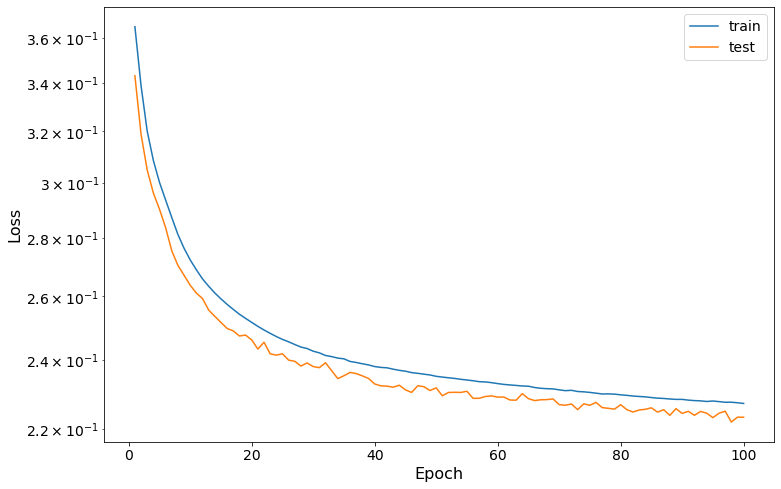

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
#plt.savefig('train.png')

In [79]:
hit_net.save('models/new_hit_net.h5')

In [59]:
#hit_net = tf.keras.models.load_model('models/new_hit_net.h5', custom_objects={'trafo_indep':trafo_indep})

In [ ]:
for i in range(100):
    
    shuffled_q_charges_train, shuffled_q_params_train, outputs_q_train = shuffle(total_charge_train, params_train)
    shuffled_q_charges_test, shuffled_q_params_test, outputs_q_test = shuffle(total_charge_test, params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history_q)+1))
    
    charge_net.fit([shuffled_q_charges_train.flatten()[:, np.newaxis], shuffled_q_params_train], outputs_q_train, batch_size=128, epochs=1, validation_data=([shuffled_q_charges_test.flatten()[:, np.newaxis], shuffled_q_params_test], outputs_q_test)) #, callbacks=[my_history_q,])

    loss_history_q.append(charge_net.history.history['loss'])
    val_loss_history_q.append(charge_net.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history_q)+1)
ax.plot(x, np.concatenate(loss_history_q), label='train')
ax.plot(x, np.concatenate(val_loss_history_q), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

Epoch 1
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 20s 23us/sample - loss: 0.5375 - val_loss: 0.5254
Epoch 2
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 19s 23us/sample - loss: 0.5339 - val_loss: 0.5259
Epoch 3
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 20s 23us/sample - loss: 0.5315 - val_loss: 0.5130
Epoch 4
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 20s 23us/sample - loss: 0.5287 - val_loss: 0.5169
Epoch 5
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 19s 23us/sample - loss: 0.5264 - val_loss: 0.5220
Epoch 6
Train on 851212 samples, validate on 8600 samples
851212/851212 [==============================] - 19s 23us/sample - loss: 0.5252 - val_loss: 0.5115
Epoch 7
Train on 851212 samples, validate on 8600 samples


In [ ]:
charge_net.save('models/new_charge_net.h5')

In [11]:
charge_net = tf.keras.models.load_model('models/new_charge_net.h5', custom_objects={'trafo_q':trafo_q})